In [4]:
import os
import io
import time
from pathlib import Path

import cv2
from matplotlib import pyplot as plt
from google.cloud import vision

In [8]:
# Instantiates a client
client = vision.ImageAnnotatorClient()

In [7]:
# Test images
test_img_dir = Path("/home/martin/projects/fydp/test_images")
for img_path in test_img_dir.glob('*.jpg'):
    print(img_path)

/home/martin/projects/fydp/test_images/receipt.jpg
/home/martin/projects/fydp/test_images/robot_comp.jpg
/home/martin/projects/fydp/test_images/kindle.jpg
/home/martin/projects/fydp/test_images/robot_clean.jpg
/home/martin/projects/fydp/test_images/ear_drops.jpg
/home/martin/projects/fydp/test_images/litter.jpg


In [64]:
def get_ocr_result(img_path):
    with io.open(img_path, 'rb') as img_file:
        content = img_file.read()
        
    t_start = time.time()
    image = vision.Image(content=content)

    # Performs label detection on the image file
    response = client.text_detection(image=image)

    print(f"Inference time: {time.time() - t_start:.2f} sec")
    
    texts = response.text_annotations

    plt.rcParams["figure.figsize"] = (10, 20)
    img = cv2.imread(img_path)

    for text in texts[1:]:
        y_vertices = [vertex.y for vertex in text.bounding_poly.vertices]
        x_vertices = [vertex.x for vertex in text.bounding_poly.vertices]

        top_left = (min(x_vertices), min(y_vertices))
        bot_right = (max(x_vertices), max(y_vertices))

        cv2.rectangle(img, top_left, bot_right, (0, 255, 0), 2)
        cv2.putText(img, text.description, (top_left[0], top_left[1] - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    plt.show()

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))


In [97]:
def get_document_ocr_result(img_path):
    with io.open(img_path, 'rb') as img_file:
        content = img_file.read()
        
    t_start = time.time()
    image = vision.Image(content=content)

    # Performs label detection on the image file
    response = client.document_text_detection(image=image)

    print(f"Inference time: {time.time() - t_start:.2f} sec")
    
    plt.rcParams["figure.figsize"] = (10, 20)
    img = cv2.imread(img_path)
    
    for page in response.full_text_annotation.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                for word in paragraph.words:
                    word_text = ''.join([
                        symbol.text for symbol in word.symbols
                    ])

                    y_vertices = [vertex.y for vertex in word.bounding_box.vertices]
                    x_vertices = [vertex.x for vertex in word.bounding_box.vertices]

                    top_left = (img.shape[1] - max(y_vertices), min(x_vertices))
                    bot_right = (img.shape[1] - min(y_vertices), max(x_vertices))
                    
                    cv2.rectangle(img, top_left, bot_right, (0, 255, 0), 2)
                    cv2.putText(img, word_text, (top_left[0], top_left[1] - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, img.shape[1] / 1000.0, (0, 255, 0), 2)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    plt.show()

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))


Inference time: 2.21 sec


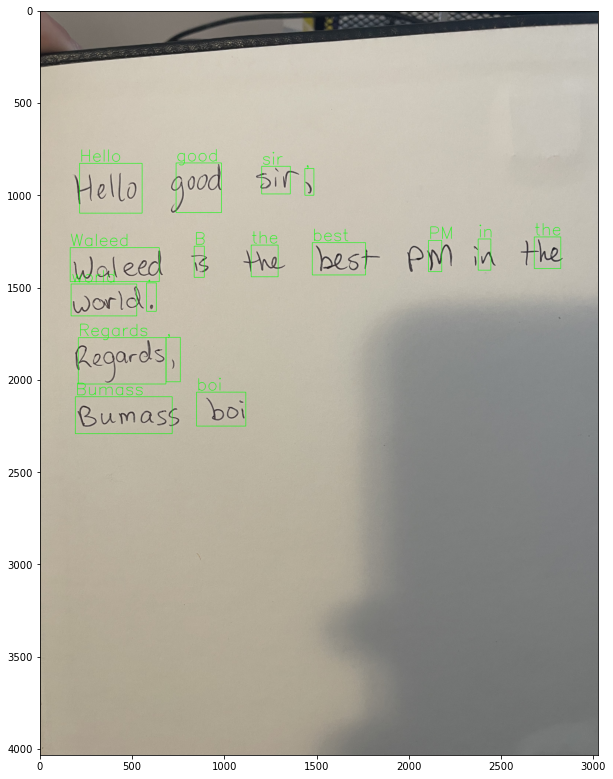

In [98]:
get_document_ocr_result(str(test_img_dir / 'handwriting.jpg'))

Inference time: 1.12 sec


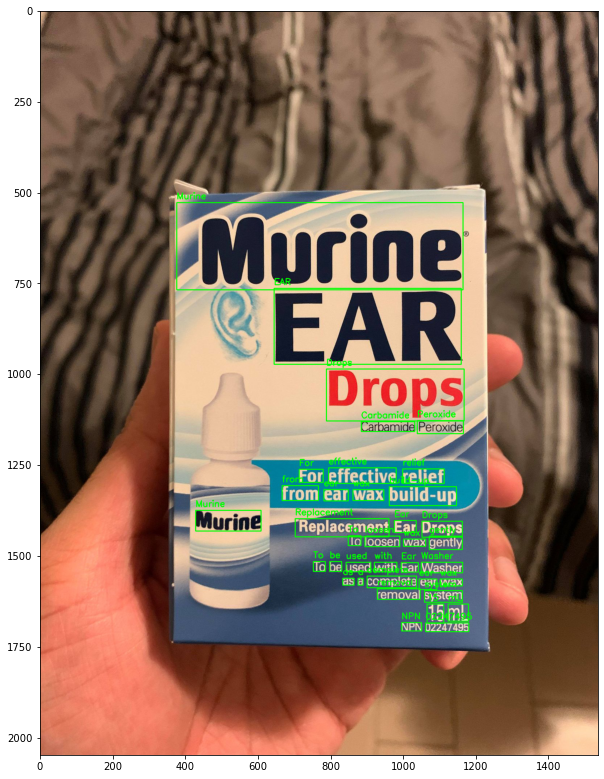

In [100]:
get_ocr_result(str(test_img_dir / 'ear_drops.jpg'))

Inference time: 1.17 sec


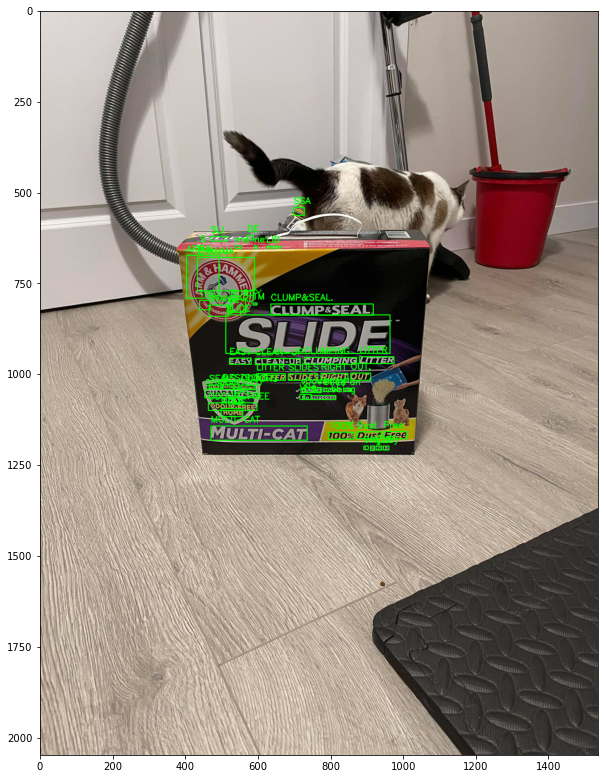

In [101]:
get_ocr_result(str(test_img_dir / 'litter.jpg'))